## Σε αυτό το σημείο της εργασίες πρέπει να συγκρίνουμε τα 3 pipelines που χρησιμοποιήσαμε στο ερώτημα 1Β μεταξύ τους

### Βήματα 
- Διαβάζουμε τα 3 ανακατσκευασμένα κείμενα
- Κάνουμε σύγκριση

In [123]:
original_text=""
pipeline1=""
pipeline2=""
pipeline3=""

In [124]:
try:
    with open('../text_files/text1.txt', 'r', encoding='utf-8') as file:
        original_text = file.read()
    print("File content successfully loaded into original_text.")
except FileNotFoundError:
    print("Error: The file 'text1.txt' was not found. Please make sure the file exists and the path is correct.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

File content successfully loaded into original_text.


In [125]:
try:
    with open("../text_files/first_pipeline_text1.txt", 'r', encoding='utf-8') as file:
        pipeline1 = file.read()
    print("File content successfully loaded into pipeline1.")
except FileNotFoundError:
    print("Error: Please make sure the file exists and the path is correct.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

File content successfully loaded into pipeline1.


In [126]:
try:
    with open("../text_files/second_pipeline_text1.txt", 'r', encoding='utf-8') as file:
        pipeline2 = file.read()
    print("File content successfully loaded into pipeline2.")
except FileNotFoundError:
    print("Error: Please make sure the file exists and the path is correct.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

File content successfully loaded into pipeline2.


In [127]:
try:
    with open("../text_files/third_pipeline_text1.txt", 'r', encoding='utf-8') as file:
        pipeline3 = file.read()
    print("File content successfully loaded into pipeline3.")
except FileNotFoundError:
    print("Error: Please make sure the file exists and the path is correct.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

File content successfully loaded into pipeline3.


## Ground truth κείμενο από το gemini

In [128]:
gemini="""Happy Dragon Boat Festival! I hope you're celebrating safely and enjoying a wonderful time.

Thank you for relaying our message to the doctor regarding his contract review. I actually received the approved message from the professor a couple of days ago. I'm very grateful for the professor's full support with our Springer proceedings publication."""

## Ground truth κείμενο από το deepseek

In [129]:
deepseek="""Today is our Dragon Boat Festival, a cherished celebration in Chinese culture. I wish you safety, joy, and prosperity during this time—may you enjoy the festivities as deeply as I hope for you.

Thank you for sharing the message regarding the doctor’s contract review. I’ve already received the approved notice from the professor a few days ago and sincerely appreciate their unwavering support for our Springer proceedings publication."""

## Ground truth κείμενο από το chat gpt

In [130]:
chat_gpt="""Today is our Dragon Boat Festival, a special celebration in our Chinese culture. It is a time to honor and wish for safety and prosperity in our lives. I hope you also enjoy this festival, as I send you my warmest wishes.

Thank you for your message and for conveying our words to the doctor regarding his upcoming contract review. This is important for all of us.

I received this message to confirm the approval. Actually, the professor shared this with me a couple of days ago. I truly appreciate the professor’s full support for our Springer proceedings publication."""

## Word Embeddings + συναρτήσεις που θα χρειαστούμε

In [131]:
import torch
import torch.nn as nn
import torch.optim as optim
from nltk.tokenize import word_tokenize
import numpy as np

def create_skip_grams(words, window_size=2):
    skip_grams = []
    for i, word in enumerate(words):
        context_words = words[max(0, i - window_size): i] + words[i + 1: i + window_size + 1]
        for context_word in context_words:
            skip_grams.append((word, context_word))
    return skip_grams

class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.output_layer = nn.Linear(embedding_dim, vocab_size) # Σωστά ορισμένο ως output_layer
        
    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        # Διόρθωση: Χρησιμοποίησε self.output_layer εδώ, όπως το όρισες στην __init__
        output = self.output_layer(embeds) 
        return output
def cosine_similarity(vec1, vec2):
    """
    Υπολογίζει την ομοιότητα συνημιτόνου μεταξύ δύο NumPy διανυσμάτων.
    """
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    
    if norm_vec1 == 0 or norm_vec2 == 0:
        return 0.0 # Αποφυγή διαίρεσης με το μηδέν
    
    return dot_product / (norm_vec1 * norm_vec2)

def get_paragraph_embedding(paragraph, model, word_to_idx_map): # Άλλαξα το όνομα παραμέτρου για σαφήνεια
    """
    Δημιουργεί ένα ενιαίο διάνυσμα (embedding) για μια παράγραφο
    κάνοντας τον μέσο όρο των embeddings των λέξεων που την απαρτίζουν.
    Χρησιμοποιεί το embedding layer από το δικό σας μοντέλο.
    """
    tokens = [word.lower() for word in word_tokenize(paragraph)]
    
    word_ids = []
    for word in tokens:
        if word in word_to_idx_map: # Χρησιμοποιούμε το word_to_idx_map
            word_ids.append(word_to_idx_map[word])
    
    if not word_ids:
        return np.zeros(model.embeddings.embedding_dim)
    
    input_tensor = torch.tensor(word_ids, dtype=torch.long).unsqueeze(0)
    
    with torch.no_grad():
        word_embeds = model.embeddings(input_tensor)
    
    paragraph_embedding = torch.mean(word_embeds, dim=1).squeeze(0)
    
    return paragraph_embedding.numpy()

### Εκπαίδευση μοντέλου στο σύνολο των τριών κειμένων

In [132]:
train_data=pipeline1+pipeline2+pipeline3

words = train_data.split()

word_to_ix = {word: i for i, word in enumerate(set(words))}
ix_to_word = {i: word for i, word in enumerate(set(words))}
vocab_size = len(word_to_ix)

embedding_dim = 10 

model = Word2Vec(vocab_size, embedding_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)  

pairs = create_skip_grams(words)
n_epochs= 50 

for epoch in range(n_epochs):
    total_loss  = 0 
    for word, context in pairs:
        model.zero_grad()
        word_idx = torch.tensor([word_to_ix[word]], dtype=torch.long)
        context_idx = torch.tensor([word_to_ix[context]], dtype=torch.long)
        
        output = model(word_idx)
        loss = criterion(output, context_idx)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss}")

    #Get word vectors 
    word_vectors = {}
    for word in word_to_ix:
        word_idx = torch.tensor([word_to_ix[word]], dtype=torch.long)
        word_vectors[word] = model.embeddings(word_idx).detach().numpy()

Epoch 0, Loss: 10249.676347494125
Epoch 10, Loss: 8178.7622282505035
Epoch 20, Loss: 7588.507743537426
Epoch 30, Loss: 7178.19621360302
Epoch 40, Loss: 6869.422655284405


In [133]:
embedding_original = get_paragraph_embedding(original_text, model, word_to_ix)
embedding_pipeline1 = get_paragraph_embedding(pipeline1, model, word_to_ix)
embedding_pipeline2 = get_paragraph_embedding(pipeline2, model, word_to_ix)
embedding_pipeline3 = get_paragraph_embedding(pipeline3, model, word_to_ix)

In [134]:
embedding_chat_gpt = get_paragraph_embedding(chat_gpt, model, word_to_ix)
embedding_gemini = get_paragraph_embedding(gemini, model, word_to_ix)
embedding_deepseek = get_paragraph_embedding(deepseek, model, word_to_ix)

In [135]:
print("\n--- Original Text vs Pipelines (Word Embeddings) ---")
sim_orig_p1_we = cosine_similarity(embedding_original, embedding_pipeline1)
print(f"Original Text vs Pipeline 1: {sim_orig_p1_we:.4f}")

sim_orig_p2_we = cosine_similarity(embedding_original, embedding_pipeline2)
print(f"Original Text vs Pipeline 2: {sim_orig_p2_we:.4f}")

sim_orig_p3_we = cosine_similarity(embedding_original, embedding_pipeline3)
print(f"Original Text vs Pipeline 3: {sim_orig_p3_we:.4f}")


--- Original Text vs Pipelines (Word Embeddings) ---
Original Text vs Pipeline 1: 0.9608
Original Text vs Pipeline 2: 0.9578
Original Text vs Pipeline 3: 0.9165


## Ground Truth LLM Texts vs Pipelines (Word Embeddings)

In [136]:
print("\nChatGPT vs Pipelines:")
sim_gpt_p1_we = cosine_similarity(embedding_chat_gpt, embedding_pipeline1)
print(f"ChatGPT vs Pipeline 1: {sim_gpt_p1_we:.4f}")
sim_gpt_p2_we = cosine_similarity(embedding_chat_gpt, embedding_pipeline2)
print(f"ChatGPT vs Pipeline 2: {sim_gpt_p2_we:.4f}")
sim_gpt_p3_we = cosine_similarity(embedding_chat_gpt, embedding_pipeline3)
print(f"ChatGPT vs Pipeline 3: {sim_gpt_p3_we:.4f}")


ChatGPT vs Pipelines:
ChatGPT vs Pipeline 1: 0.8642
ChatGPT vs Pipeline 2: 0.8787
ChatGPT vs Pipeline 3: 0.9349


In [137]:
print("\n Gemini vs Pipelines:")
sim_gpt_p1_we = cosine_similarity(embedding_gemini, embedding_pipeline1)
print(f"Gemini vs Pipeline 1: {sim_gpt_p1_we:.4f}")
sim_gpt_p2_we = cosine_similarity(embedding_gemini, embedding_pipeline2)
print(f"Gemini vs Pipeline 2: {sim_gpt_p2_we:.4f}")
sim_gpt_p3_we = cosine_similarity(embedding_gemini, embedding_pipeline3)
print(f"Gemini vs Pipeline 3: {sim_gpt_p3_we:.4f}")


 Gemini vs Pipelines:
Gemini vs Pipeline 1: 0.5750
Gemini vs Pipeline 2: 0.6106
Gemini vs Pipeline 3: 0.7090


In [138]:
print("\nDeepseek vs Pipelines:")
sim_gpt_p1_we = cosine_similarity(embedding_deepseek, embedding_pipeline1)
print(f"ChatGPT vs Pipeline 1: {sim_gpt_p1_we:.4f}")
sim_gpt_p2_we = cosine_similarity(embedding_deepseek, embedding_pipeline2)
print(f"ChatGPT vs Pipeline 2: {sim_gpt_p2_we:.4f}")
sim_gpt_p3_we = cosine_similarity(embedding_deepseek, embedding_pipeline3)
print(f"ChatGPT vs Pipeline 3: {sim_gpt_p3_we:.4f}")


Deepseek vs Pipelines:
ChatGPT vs Pipeline 1: 0.5695
ChatGPT vs Pipeline 2: 0.6012
ChatGPT vs Pipeline 3: 0.8002


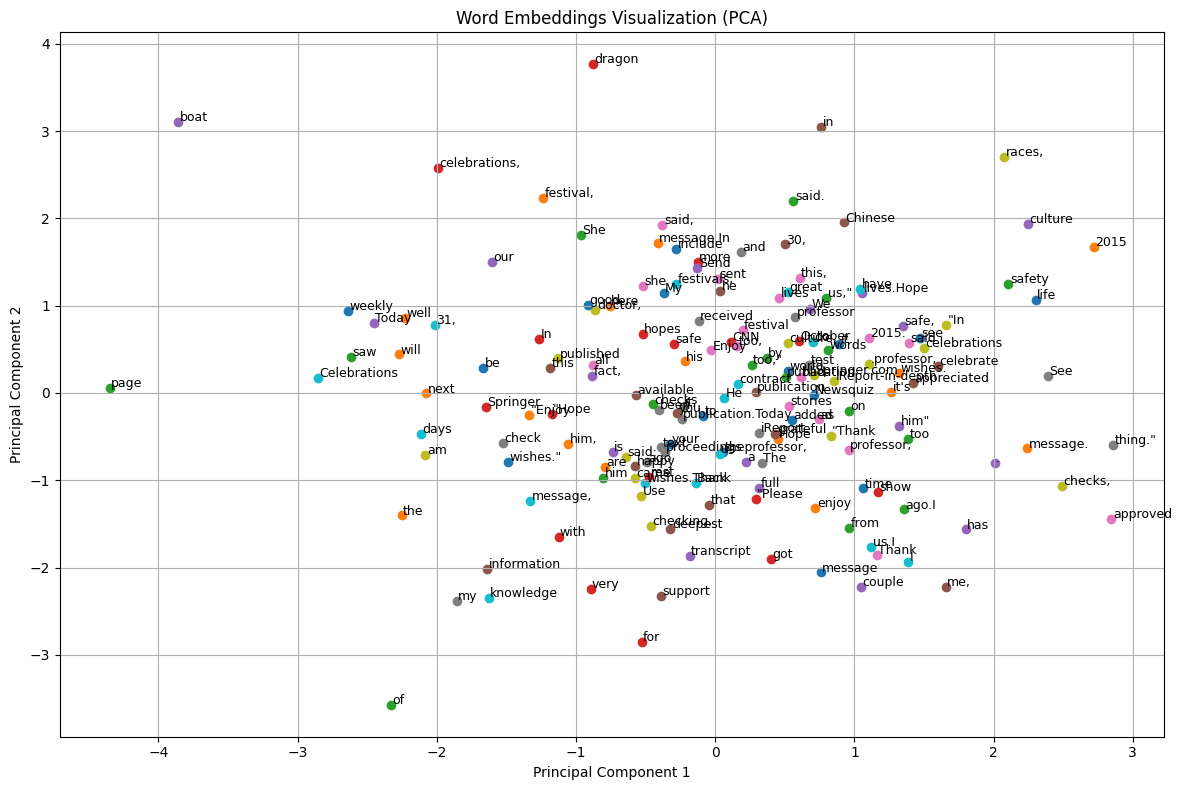

In [139]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Συγκεντρώνουμε όλα τα word embeddings σε ένα array
labels = []
vectors = []

for word, idx in word_to_ix.items():
    word_tensor = torch.tensor([idx], dtype=torch.long)
    embedding = model.embeddings(word_tensor).detach().numpy()[0]
    labels.append(word)
    vectors.append(embedding)

vectors = np.array(vectors)

# Μείωση διάστασης με PCA σε 2D
pca = PCA(n_components=2)
reduced = pca.fit_transform(vectors)

# Plot
plt.figure(figsize=(12, 8))
for i, label in enumerate(labels):
    x, y = reduced[i]
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, label, fontsize=9)

plt.title("Word Embeddings Visualization (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()
